In [3]:
### Using the Breast Cancer Wisocnsin Dataset
## cols 1-2 have id number and M or B designation and 3-32 have 30
## real value features

import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)

## Assign 30 features to X using label incoder transform MB to integers

from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

le.transform(['M', 'B'])

## Split into 80/20 training test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)


In [5]:
## Can chain scaling, dimension reduction, and model fitting into 
## a single pipeline. 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## Pipeline takes a list of tuples (aribitary identifier, function)
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state = 1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))


Test Accuracy: 0.947


### Using K-fold cross validation to assess model performance

#### Holdout method

Split into different training and test sets. Interested in tuning and comparing parameters. Instead of model tuning on the test set, can make a training set, validation set, and test set. Training set is used to test different models, and performance on validation set is used for model selection. Final performance metric comes on the test set.

Splitting the validation set into k-folds reduces sampling bias.

In k-fold cross validation we randomly split the training data into k folds without replacement- where k-1 folds are used for the model training and one isused for testing. Procedure is repeated k times so that we obtain k models and performance estimates. Average out the perfomance to get a better estimate of the model performance. After finidng optimal hyperparameter values, can retrain using whole training set and get a final performance estimate using an independent test set. 

k= 10 is generally a good number but with small training sets will want to increase the number of folds

Can use Leave-one-out cross validation when working with very small datasets. 

Stratified cross validation can be a better technique where class proportions are preserved in each fold to ensure that each fold is representativeof the training set.

In [8]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train, n_folds = 10, random_state = 1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

print('CV accuracy: %.3f +/- %.3f' % ( np.mean(scores), np.std(scores)))


Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


In [9]:
### Uses Sklearn directly to fit and score

from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator = pipe_lr,
                        X = X_train,
                        y = y_train,
                        cv = 10,
                        n_jobs = 1)
print ('CV accuracy scores: %s' % scores)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))



CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


Additional CV resources 

M. Markatou, H. Tian, S. Biswas, and G. M. Hripcsak. Analysis of Variance of Cross-validation Estimators of the Generalization Error. Journal of Machine Learning Research, 6:1127–1168, 2005)

B. Efron and
R. Tibshirani. Improvements on Cross-validation: The 632+ Bootstrap Method. Journal of the American Statistical Association, 92(438):548–560, 1997

#### Discovering bias and variance problems with learning curves

/Users/andrew.moskowitz/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


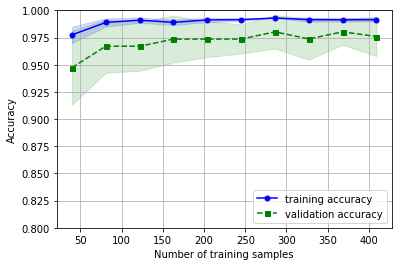

In [10]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', random_state = 0))
])

train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= np.linspace(0.1, 1.0, 10),
                                                       cv=10,
                                                       n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis = 1)
plt.plot(train_sizes, train_mean, color = 'blue', marker='o',
        markersize=5, label = 'training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color = 'green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std, 
                alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

#### Addressing overfitting and underfitting with validation curves

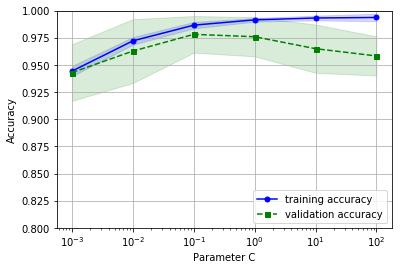

In [19]:
# Similar to learning curves, but focused on model parameters
# e.g., the inverse regularization parameter in logistic regression

from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr,
    X=X_train, 
    y = y_train,
    param_name = 'clf__C',
    param_range = param_range,
    cv = 10)
train_mean = np.mean(train_scores, axis=1)
train_sd = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color ='blue', marker = 'o', markersize = 5, label = 'training accuracy')
plt.fill_between(param_range, train_mean + train_sd, train_mean - train_sd, alpha = 0.15, color = 'blue')
plt.plot(param_range, test_mean, color = 'green', linestyle='--', marker = 's', markersize = 5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std,
                alpha=0.15, color = 'green')

plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

### Fine Tuning using GridSearch

Grid search is a brute force exhaustive search paradigm in which we test 

In [21]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
              'clf__kernel' : ['linear']},
             {'clf__C': param_range,
             'clf__gamma': param_range,
             'clf__kernel':['rbf']}]
gs = GridSearchCV(estimator = pipe_svc, param_grid=param_grid,
                 scoring='accuracy',
                 cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print gs.best_params_

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [22]:
## use best esimator on the test set

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


Can and should (when parameter space is high dimensional) use RandomizedSearchCV


#### Algorithm selection using nested cross validation

NEsted cross validation

- outer loop to split data into training and test folds
- inner loop to select model using kfold cross validation on the training fold 
- after model selection the test fold is used to evaluate model performance 

In [23]:
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid=param_grid,
                 scoring = 'accuracy', 
                 cv = 2,
                 n_jobs = -1)
scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)
print ('CV accuracy: %.3f +/- %.3f' %( np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [27]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=0),
                 param_grid=[
                     {'max_depth': [1,2,3,4,5,6,7,None]}
                 ],
                 scoring='accuracy',
                 cv = 5)
scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy', 
                        cv = 2)
print('CV accuracy: %.3f +/- %.3f' % (
np.mean(scores), np.std(scores)))


CV accuracy: 0.906 +/- 0.015


#### Looking at different performance evaluation metrics

Accuracy is a good metric to evaluate models, but precision, recall, and F1-score are also used to measure a model's relevance

The confusion matrix looks like this:

                     Predicted Class
                       P .  |   N . 
                   -------------------
    Act class   P | True Pos| False Neg|
                  |--------------------|
                N |False Pos| True Neg |
                  |--------------------|
                  
Can use the confuision_matrix method to build matrix

In [29]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


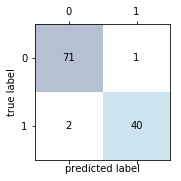

In [30]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, 
               s=confmat[i, j],
               va = 'center', ha = 'center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

#### Optimize precision and recall of classification model

Both prediction error (ERR) and accuracy (ACC) are good to determine how many samples have been misclassified. 

Error = FP + FN / All samples (falses over everything)  

Accuracy = TP + TN / All samples (trues over everything) = 1-ERR

True positive rate and false positive rate (Good for imbalanced class problems)

FPR = FP/N = FP/(FP + TN)
  
TPR = TP/P = TP/(FN + TP

Precision (PRE) and Recall (REC) are realted to FPR and TPR

PRE = TP / (TP + FP)
  
REC = TPR = TP / P = TP / (FN + TP)

In practice a combination of Precisiona nd recall is used: the F1-Score

F1 = 2(PRE x REC)/(PRE + REC)

Can import all from SK-learn and use all int he optimization for the grid search

In [31]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred = y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [33]:
### Can construct our own positive class label by creating custom 
### scorer function

from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                 scoring = scorer,
                 cv=10)

gs

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'clf__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf__kernel': ['linear']}, {'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=0), verbose=0)

## Plotting the Receiver operating Characteristic (ROC)

ROC plot performance ERT to the false positive and true positive rates. 

Diagonal of ROC is random guessing, and models below the diagonal are worse than chance

Perfect classifier would fall into the top-left corner of the graph with a true positive rate of 1 and a false positive rate of 0. 

Based on the ROC curve, can compute the area-under-the-curve (AUC)

(Similar ROC curves, can compute precision-recall curves for different probability thresholds). 

/Users/andrew.moskowitz/anaconda2/lib/python2.7/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(self.codes)))


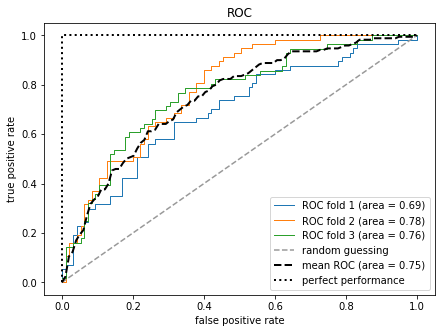

In [35]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(penalty='l2',
                                             random_state=0, 
                                             C = 100.0))])

X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train, n_folds = 3, random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                        y_train[train]).predict_proba(X_train2[test])
    fpr,tpr, thresholds = roc_curve(y_train[test], 
                                   probas[:, 1],
                                   pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label = 'ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0,1], [0,1],
        linestyle = '--',
        color = (0.6, 0.6, 0.6),
        label = 'random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
        label = 'mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0,0,1],
        [0,1,1],
        lw=2,
        linestyle = ':',
        color = 'black',
        label = 'perfect performance')
plt.xlim([-.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC')
plt.legend(loc = "Lower right")
plt.show()
    

In [36]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4,14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true = y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


### Scoring Metrics for Multiclass classificaiton

Can use macro and micro averaging mdethods to extend scoring to multiclass problems via one vs all classification

Microaveraging is calculate from the inidividual TP, TN, FP, FNs. 

Micro avg of the precision score of a k-class system would be:

    TP_1 + ... + TP_k 
    -----------------------------------
    TP1 + ... TP_k + FP_1 + ... + FP_k
    
The Macro average is simple calculated as the average scores of the different systems

    PRE_Macro = PRE_1 + ... + PRE_k 
                --------------------
                        k
                   
Micro-averaging is useful if we want to weight each instance or prediction equally, whereas macro averages weight all classes equally to evaluate overall performance of a classifier with regard to the most frequent class labels. 


In [37]:
pre_scorer = make_scorer(score_func = precision_score,
                        pos_label = 1,
                        greater_is_better = True,
                        average='micro')